## Electron density visualisation

The first-order electron density operator $\hat{\rho}(\mathbf{r})$ is defined in first quantisation as
$$
\hat{\rho}(\mathbf{r}) = \sum_{i}^N \delta(\mathbf{r_i} - \mathbf{r}).
$$

We define the Hartree-Fock Slater determinant $\ket{\Phi} = |\phi_1 \phi_2 ... \phi_N|$ as 
$$
 \prod_i a_i^\dag \ket{0},
 $$
such that we can define the density operator in second quantisation (cf. Helgaker CH1) as
$$\hat{\rho}(\mathbf{r}) = \sum_{pq}^K \rho(\mathbf{r})_{pq} a_p^\dag a_q$$
with
$$
\rho(\mathbf{r})_{pq} = \int d\mathbf{r}' \phi_p^*(\mathbf{r}') \delta(\mathbf{r}' - \mathbf{r}) \phi_q(\mathbf{r}') =
 \phi_p^*(\mathbf{r})\phi_q(\mathbf{r})
 $$

This gives us the first-order electron density
$$
 \bra{\Phi}\hat{\rho}(\mathbf{r})\ket{\Phi} = \sum_{pq}^K \phi_p^*(\mathbf{r})\phi_q(\mathbf{r}) \bra{\Phi}a_p^\dag a_q\ket{\Phi} = 
\sum_{pq}^K \phi_p^*(\mathbf{r})\phi_q(\mathbf{r}) \gamma_{pq} = \sum_i^{N_{occ}} \phi_i^*(\mathbf{r})\phi_i(\mathbf{r}).
$$
Expanding the MOs in a basis of atomic orbitals $\chi$
$$
\ket{\phi_p} = \sum_\mu C_{\mu i} \ket{\chi_\mu}
$$
and defining the first order density matrix (1-RDM)
$$
D_{\mu\nu} = \sum_i^{N_{occ}} C_{\mu i} C_{\nu i}^*
$$
we find
$$
\bra{\Phi}\hat{\rho}(\mathbf{r})\ket{\Phi} = \sum_{\mu \nu} D_{\nu\mu} \chi_\mu^*(\mathbf{r}) \chi_\nu(\mathbf{r}).
$$

In [1]:
# import packages
import pyscf
import numpy as np

In [2]:
# create molecule and run RHF calculation
mol = pyscf.gto.Mole()
mol.build(
    atom = """H -0.68 0 0; H 0.68 0 0""", # default distance unit is angstrom
    basis = "sto-3g",
    unit = 'bohr',  # specify Bohr units: default is A but underlying calculations of AO stuff is in Bohr.
    symmetry="C1"
)
mf = pyscf.scf.RHF(mol) # init HF object
mf.kernel() # run SCF

converged SCF energy = -1.11744993198047


-1.1174499319804712

We need to obtain the values of each AO for each point in space. This can be done using the `eval_gto` method. The cartesian point in question must be input as a `np.array`:

In [3]:
print('nao: ', mol.nao)
ao_values = mol.eval_gto('GTOval_cart', np.array([[0, 1, 0]]))
ao_values[0]

nao:  2


array([0.17461002, 0.17461002])

This provides the value of each separate AO at the specified point $r$.
To perform the contraction with the 1-RDM in AO basis, we need to perform the outer product of the vector describing each AO's value to obtain a matrix specifying all pairwise combinations of the AOs.

In [4]:
ao_values_matrix = np.einsum('i, j -> ij', ao_values[0], ao_values[0])
ao_values_matrix

array([[0.03048866, 0.03048866],
       [0.03048866, 0.03048866]])

Now we can contract this with the density matrix:

In [5]:
density_matrix = mf.make_rdm1()
np.einsum('ij, ij ->', density_matrix, ao_values_matrix)

0.07288785033779126

Let's perform this for a whole grid to get the final visualisation:

In [6]:
def get_el_density_at_r(r_vec, mol, hf_obj):
    # get density matrix
    density_matrix = hf_obj.make_rdm1()
    # get value of each AO at location r
    ao_values = mol.eval_gto('GTOval_cart', np.array([r_vec]))
    ao_values_matrix = np.einsum('i, j -> ij', ao_values[0], ao_values[0])

    # perform contraction
    return np.einsum('ij, ij ->', density_matrix, ao_values_matrix)

In [7]:
# Define the grid resolution and range
x_min, x_max = -3.0, 3.0  # Bohr
y_min, y_max = -3.0, 3.0  # Bohr
grid_points = 144  # Number of points along each axis

# Create the x and y coordinates for the grid
x_coords = np.linspace(x_min, x_max, grid_points)
y_coords = np.linspace(y_min, y_max, grid_points)

# Initialize the 2D array to store electron densities
electron_density = np.zeros((grid_points, grid_points))

# Compute electron density at each point in the xy-plane
for i, x in enumerate(x_coords):
    for j, y in enumerate(y_coords):
        # Create the r_vec for the xy-plane, z = 0
        r_vec = [x, y, 0.0]
        # Compute electron density at this point
        electron_density[i, j] = get_el_density_at_r(r_vec, mol, mf)

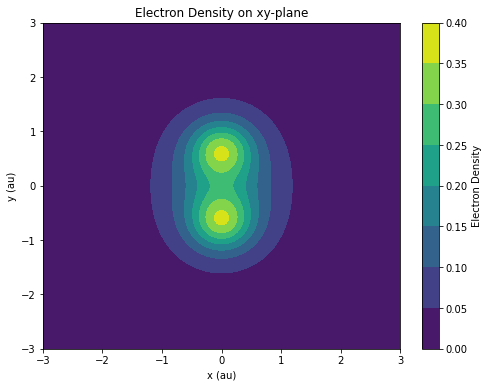

In [8]:
import matplotlib.pyplot as plt

# Create a meshgrid for plotting
X, Y = np.meshgrid(x_coords, y_coords)

# Plot the electron density using contour plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, electron_density, cmap='viridis')
plt.colorbar(cp, label='Electron Density')
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.title('Electron Density on xy-plane')
plt.show()


## Benzene

In [12]:
# benzene
mol = pyscf.gto.Mole()
mol.build(
    atom = """
    C   0.000000   1.396792   0.000000
    H   0.000000   2.481081   0.000000
    C  -1.209657   0.698396   0.000000
    H  -2.147732   1.240540   0.000000
    C  -1.209657  -0.698396   0.000000
    H  -2.147732  -1.240540   0.000000
    C   0.000000  -1.396792   0.000000
    H   0.000000  -2.481081   0.000000
    C   1.209657  -0.698396   0.000000
    H   2.147732  -1.240540   0.000000
    C   1.209657   0.698396   0.000000
    H   2.147732   1.240540   0.000000
    """,  # Coordinates are in angstroms by default
    basis = "sto-3g",
    unit = 'angstrom',
    symmetry = "C1" 
)

# Initialize the RHF object
mf = pyscf.scf.RHF(mol)

# Run the SCF calculation
mf.kernel()


converged SCF energy = -227.890632747652


-227.89063274765155

In [13]:
# Define the grid resolution and range
x_min, x_max = -4.5, 4.5  # Bohr
y_min, y_max = -4.5, 4.5  # Bohr
grid_points = 144  # Number of points along each axis

# Create the x and y coordinates for the grid
x_coords = np.linspace(x_min, x_max, grid_points)
y_coords = np.linspace(y_min, y_max, grid_points)

# Initialize the 2D array to store electron densities
electron_density = np.zeros((grid_points, grid_points))

# Compute electron density at each point in the xy-plane
for i, x in enumerate(x_coords):
    for j, y in enumerate(y_coords):
        # Create the r_vec for the xy-plane, z = 0
        r_vec = [x, y, 0.0]
        # Compute electron density at this point
        electron_density[i, j] = get_el_density_at_r(r_vec, mol, mf)

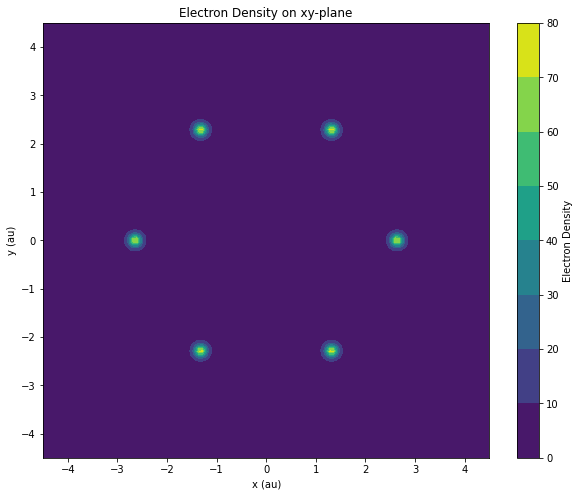

In [17]:
# Create a meshgrid for plotting
X, Y = np.meshgrid(x_coords, y_coords)

# Plot the electron density using contour plot
plt.figure(figsize=(10, 8))
cp = plt.contourf(X, Y, electron_density, cmap='viridis')
plt.colorbar(cp, label='Electron Density')
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.title('Electron Density on xy-plane')
plt.show()


We don't see any electron density near the hydrogen atoms. This is because the density around the higher charge carbon atoms is much larger. We can see their presence when we plot the logarithm.

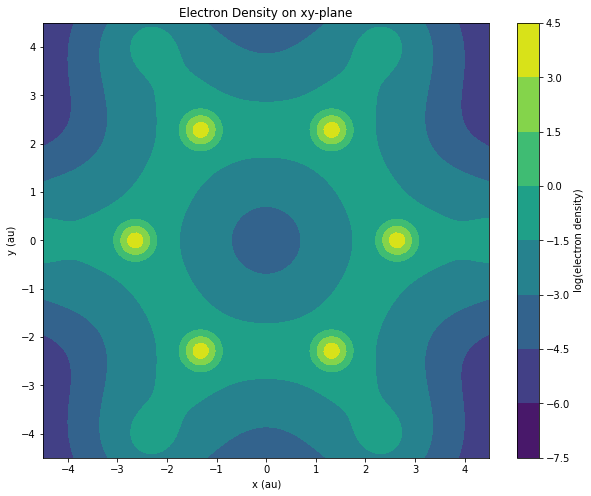

In [18]:
# Plot the electron density using contour plot
plt.figure(figsize=(10, 8))
cp = plt.contourf(X, Y, np.log(electron_density), cmap='viridis')
plt.colorbar(cp, label='log(electron density)')
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.title('Electron Density on xy-plane')
plt.show()
